In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import shutil
import numpy as np

['9_data_1', '9_data_2']

In [1]:
from datasets import wikiset
wikiset.make_embeddings(wikiset.get('full'),'wiki_segments_trans_300',trunc=300)
        

d:\misc\projects\python\magister\data\wiki_727K.tar.bz2 found: True
d:\misc\projects\python\magister\data\wiki_test_50.tar.bz2 found: True
Making sentence embeddings...
Loading sentence bert...
Loading sentence bert done in 25.57 s
Embedding sentences:[..........][127/127] => DONE [0h 2min 7s][eta: 0h 0min 0s]   min 7s][eta: 0h 0min 0s]      
Making sentence embeddings done in 477.60 s


In [7]:
## load embeddings
import numpy as np
from datasets import EmbeddedDataset
from algorithms import segments
import matplotlib.pyplot as plt
with EmbeddedDataset('choi_segments.npz') as ds:
    print(ds.get_embeddings()[-10:-1])
    seg, emb = ds.get_file('data/961796')
    print(np.min(ds.segment_lengths()))
    print(seg)
    print(segments.tags_to_array(seg))


['3-11/90.ref_emb', '3-11/91.ref_emb', '3-11/92.ref_emb', '3-11/93.ref_emb', '3-11/94.ref_emb', '3-11/95.ref_emb', '3-11/96.ref_emb', '3-11/97.ref_emb', '3-11/98.ref_emb']


KeyError: 'data/961796_seg is not a file in the archive'

[(57, 57), (73, 73), (65, 65), (65, 65), (66, 66), (60, 60), (79, 79), (75, 75), (81, 81), (74, 74)]
[(57, 57), (73, 73), (65, 65), (65, 65), (66, 66), (60, 60), (79, 79), (75, 75), (81, 81), (74, 74)]


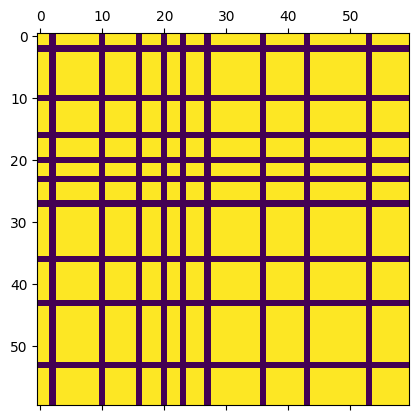

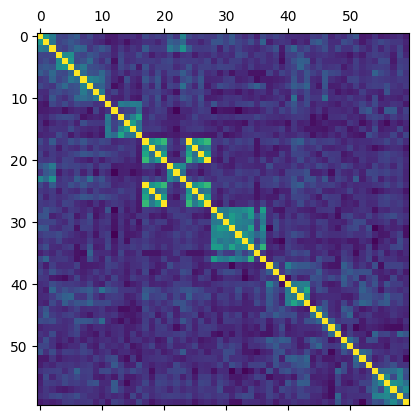

In [8]:
def make_segmat(seg,emb):
    segs = segments.tags_to_array(seg)
    ezemb = np.ones_like(emb[:,0]) * segs
    return np.array([[1-np.clip(i+j,0,1) for j in ezemb] for i in ezemb])

with EmbeddedDataset('choi_segments.npz') as ds:
    Es = ds.get_embeddings()[0:10]
    elist = [np.inner(e,e) for e in ds[Es]]
    ylist = [make_segmat(ds[ds.segmentation(e)],ds[e]) for e in Es]

print([e.shape for e in elist])
print([y.shape for y in ylist])
plt.matshow(ylist[5])
plt.matshow(elist[5])


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

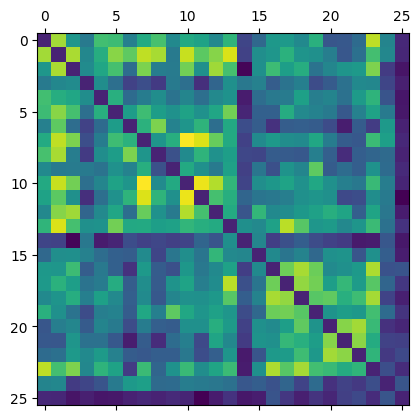

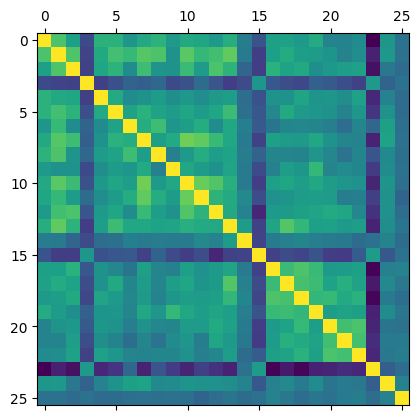

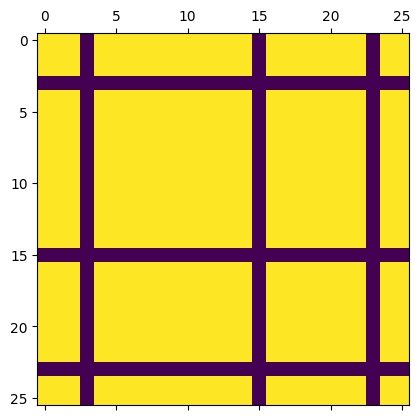

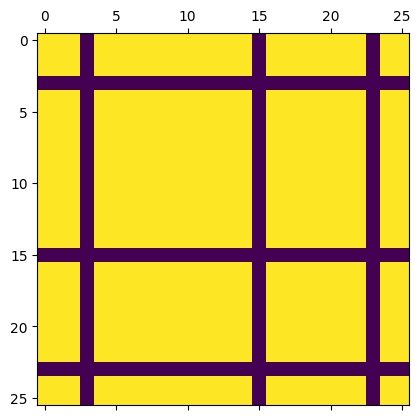

In [40]:
from algorithms import segments
from scipy import signal

mat = np.inner(emb,emb)
segs = segments.tags_to_array(seg)
import matplotlib.pyplot as plt
plt.matshow(mat - np.identity(mat.shape[0]))
eemb = emb * (((segs+1)*-2)+3)[:,np.newaxis]
ezemb = np.ones_like(emb) * segs[:,np.newaxis]
plt.matshow(np.inner(eemb,eemb))
def make_segmat(seg,emb):
    segs = segments.tags_to_array(seg)
    ezemb = np.ones_like(emb[:,0]) * segs
    return np.array([[1-np.clip(i+j,0,1) for j in ezemb] for i in ezemb])

plt.matshow(make_segmat(seg,emb))
plt.matshow(np.mean(mat)*make_segmat(seg,emb))

In [9]:
import tensorflow as tf
autoencoder = tf.keras.models.load_model('models/autoencoder-100e-10k')

In [79]:
import tensorflow as tf
input = tf.keras.layers.Input(shape=(None,None, 1))

# Encoder
ds = tf.keras.layers.BatchNormalization()(input)
x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds =tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])


autoencoder = tf.keras.Model(input, ds)
mat = np.inner(emb,emb)
autoencoder(np.reshape(mat,(1,*mat.shape,1)))
autoencoder.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 batch_normalization_16 (BatchN  (None, None, None,   4          ['input_20[0][0]']               
 ormalization)                  1)                                                                
                                                                                                  
 conv2d_105 (Conv2D)            (None, None, None,   416         ['batch_normalization_16[0][0]'] 
                                16)                                                        

In [64]:
from math import floor
import tensorflow as tf
class Wiki727Sequence(tf.keras.utils.Sequence):

    def __init__(self, emb_dataset, batch_size):
        self.emb_ds = emb_dataset
        self.emb_ds.open()
        self.batch_size = batch_size
        self.segs_keys = self.emb_ds.get_segments()
        self.embs_keys = self.emb_ds.get_segments()
        self.len = len(self.segs_keys)
        self.emb_ds.close()

    def __len__(self):
        return floor(self.len/self.batch_size)

    def __getitem__(self, idx):
        self.emb_ds.open()
        Es = self.emb_ds.get_embeddings()[idx*self.batch_size : (idx + 1)*self.batch_size]
        
        batch_x = [np.inner(e,e) for e in self.emb_ds[Es]]

        batch_y = tf.ragged.constant([[make_segmat(self.emb_ds[ds.segmentation(e)],self.emb_ds[e]) for e in Es]])
        self.emb_ds.close()
        print(batch_x.shape)

        return batch_x,batch_y

In [80]:
from common import stage
epochs = 100
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

with EmbeddedDataset('wiki_segments.npz') as ds:
    ksegs, kembs = ds.get_segments(), ds.get_embeddings()
    last_loss = 0
    for epoch in range(epochs):
        bar = stage.ProgressBar(f"Epoch [{epoch}/{epochs}] (Loss: {last_loss})",len(ksegs)-10)
        last_loss = 0
        for step in range(len(ksegs)-10):
            bar.update(kembs[step])
            emb, seg = ds[kembs[step]], ds[ksegs[step]]
            X = np.inner(emb,emb)
            X = np.reshape(X,(1,*X.shape,1))
            Y = make_segmat(seg,emb)
            Y = np.reshape(Y,(1,*Y.shape,1))

            with tf.GradientTape() as tape:
                output = autoencoder(X,training= True)
                lossval = loss_fn(Y,output)
            grads = tape.gradient(lossval,autoencoder.trainable_weights)
            optimizer.apply_gradients(zip(grads,autoencoder.trainable_weights))
            last_loss += lossval
        bar.end()


    

Epoch [0/100] (Loss: 0):[..........][40/40] => DONE [0h 0min 26s][eta: 0h 0min 0s]    0min 0s]    
Epoch [1/100] (Loss: 23.579456329345703):[..........][40/40] => DONE [0h 0min 26s][eta: 0h 0min 0s]    0min 0s]    
Epoch [2/100] (Loss: 7.588850021362305):[..........][40/40] => DONE [0h 0min 26s][eta: 0h 0min 0s]    0min 0s]    
Epoch [3/100] (Loss: 7.336544513702393):[..........][40/40] => DONE [0h 0min 28s][eta: 0h 0min 0s]    0min 0s]    
Epoch [4/100] (Loss: 7.1948466300964355):[..........][40/40] => DONE [0h 0min 30s][eta: 0h 0min 0s]    0min 0s]    
Epoch [5/100] (Loss: 7.110968589782715):[..........][40/40] => DONE [0h 0min 26s][eta: 0h 0min 0s]    0min 0s]    
Epoch [6/100] (Loss: 7.0641584396362305):[..........][40/40] => DONE [0h 0min 26s][eta: 0h 0min 0s]    0min 0s]    
Epoch [7/100] (Loss: 7.034617900848389):[..........][40/40] => DONE [0h 0min 25s][eta: 0h 0min 0s]    0min 0s]    
Epoch [8/100] (Loss: 7.008620262145996):[..........][40/40] => DONE [0h 0min 25s][eta: 0h 0mi

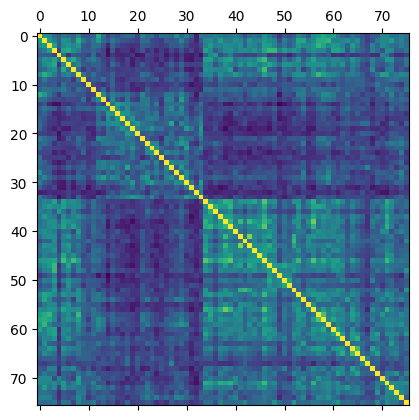

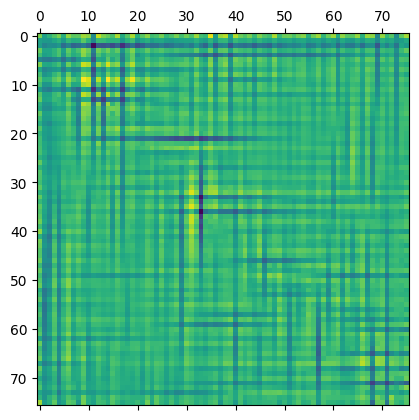

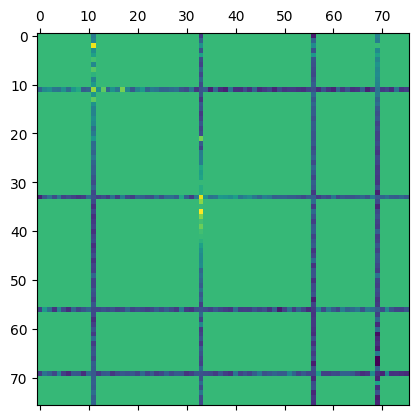

In [10]:
mat = np.inner(emb,emb)
x= np.reshape(mat,(1,*mat.shape,1))
y=autoencoder(x)
plt.matshow(mat)
plt.matshow(np.reshape(y,mat.shape))
plt.matshow(1-(np.reshape(y,mat.shape)*(1-make_segmat(seg,emb))))

In [82]:
autoencoder.save('models/autoencoder-100e-10k')

INFO:tensorflow:Assets written to: models/autoencoder-100e-10k\assets


INFO:tensorflow:Assets written to: models/autoencoder-100e-10k\assets


0.29812944
0.20978339


array([ True,  True, False,  True,  True, False,  True,  True,  True,
        True, False, False])

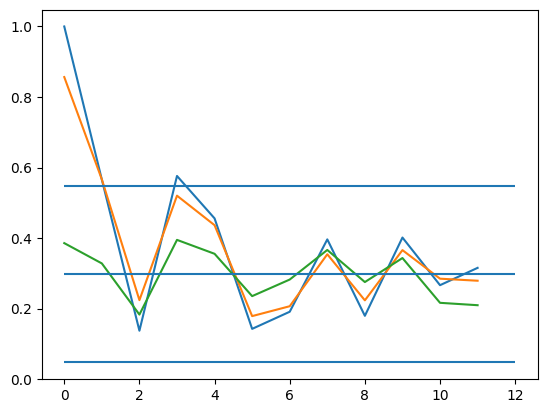

In [48]:

plt.plot(mat[0])
plt.plot(np.convolve(mat[0],[0.1,0.8,0.1],'same'))
print(np.mean(mat))
#plt.plot(mat[145])
print(np.mean(mat[-1]))
plt.plot(np.mean(mat,0))
mean_cross = np.mean(np.mean(mat,0))
std_cross = np.mean(np.std(mat,0))
plt.hlines([mean_cross, mean_cross + std_cross, mean_cross-std_cross],0,len(emb))

tau = np.mean(np.mean(mat,0))-np.std(np.mean(mat,0))/2
np.mean(mat,0) > tau

(40, 512), (1, 512)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

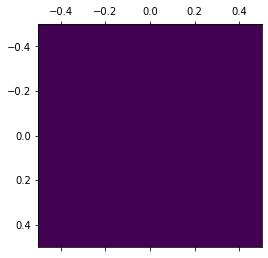

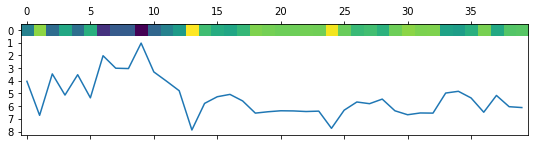

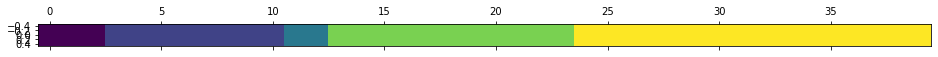

In [11]:
from datasets import EmbeddedDataset
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import kmeans, whiten
with EmbeddedDataset('wiki_segments.npz') as ds:
    seg,emb = ds.get_file('data/123319')

e = whiten(emb, check_finite = False)
s,c = kmeans(e,1)
print(f'{emb.shape}, {s.shape}')
z = np.array([[k.dot(t) for k in emb] for t in s])
plt.matshow(np.array([[j.dot(i) for i in s] for j in s]))
plt.matshow(z)
plt.plot(z[0])

plt.matshow([seg])
np.argmax(z,0)

In [19]:
### block comparison of embedding
from algorithms import simple
import numpy as np
from scipy.cluster.vq import whiten

d = np.vstack([np.ones(10)*i] for i in range(5))
d = whiten(d)
print(d, d.shape)

v = np.lib.stride_tricks.sliding_window_view(d,3,0)
print(v, v.shape)

v = np.array([u/np.sqrt(u.dot(u.T)) for u in np.sum(v,2)])
print(v, v.shape)



[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678
  0.70710678 0.70710678 0.70710678 0.70710678]
 [1.41421356 1.41421356 1.41421356 1.41421356 1.41421356 1.41421356
  1.41421356 1.41421356 1.41421356 1.41421356]
 [2.12132034 2.12132034 2.12132034 2.12132034 2.12132034 2.12132034
  2.12132034 2.12132034 2.12132034 2.12132034]
 [2.82842712 2.82842712 2.82842712 2.82842712 2.82842712 2.82842712
  2.82842712 2.82842712 2.82842712 2.82842712]] (5, 10)
[[[0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]
  [0.         0.70710678 1.41421356]]

 [[0.70710678 1.41421356 2.12132034]
  [0.70710678 1

C:\Users\Radoslaw\AppData\Local\Temp/ipykernel_18280/1870392530.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  d = np.vstack([np.ones(10)*i] for i in range(5))


In [8]:
from datasets import choiset, wikiset
from common import files, stage
import numpy as np
import tensorflow_hub as hub
import tensorflow_text
import os, shutil

choiset.make_embeddings(choiset.get(),'choi_segments_cnn', 'cnn')
wikiset.make_embeddings(wikiset.get(),'wiki_segments')
wikiset.make_embeddings(wikiset.get(),'wiki_segments_cnn','cnn')

f:\progs\python\magister\data\Choi-3-11.zip found: True
Making sentence embeddings...
Loading sentence bert...
Loading sentence bert done in 0.00 s
Embedding sentences:[..........][300/300] => DONE [0h 2min 7s][eta: 0h 0min 0s]    0s]      
Making sentence embeddings done in 138.54 s
f:\progs\python\magister\data\wiki_727K.tar.bz2 found: True
f:\progs\python\magister\data\wiki_test_50.tar.bz2 found: True
Making sentence embeddings...
Loading sentence bert...
Loading sentence bert done in 0.00 s
Embedding sentences:[..........][50/50] => DONE [0h 1min 58s][eta: 0h 0min 0s]   n 0s]     
Making sentence embeddings done in 125.73 s
f:\progs\python\magister\data\wiki_727K.tar.bz2 found: True
f:\progs\python\magister\data\wiki_test_50.tar.bz2 found: True
Making sentence embeddings...
Loading sentence bert...
Loading sentence bert done in 0.00 s
Embedding sentences:[..........][50/50] => DONE [0h 0min 15s][eta: 0h 0min 0s]   n 0s]    
Making sentence embeddings done in 16.96 s


Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 

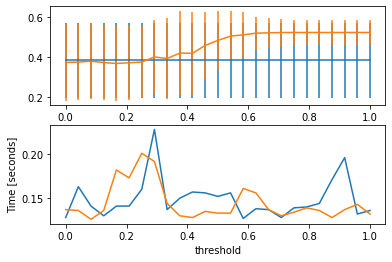

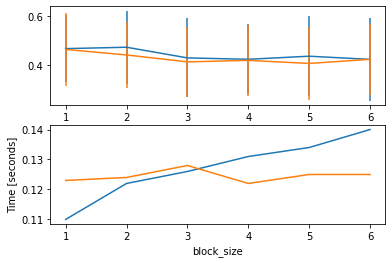

In [1]:
from evaluation import evaluate_segmenter
from algorithms import simple, graphseg, block_comparison
from datasets import EmbeddedDataset
import matplotlib.pyplot as plt
import numpy as np
import time


def evaluate_range(dataset,segmenter_factory,argname, values, window_range = 4,**kwargs):
    Ms, Ss = [], []
    Ts = []
    for x in values:
        seg = segmenter_factory(**{argname:x,**kwargs})
        start = time.time()
        p,w = evaluate_segmenter(dataset,seg,window_range)
        end = time.time()
        Ms.append(np.mean(p))
        Ss.append(np.std(w))
        Ts.append(end - start)
    plt.subplot(2,1,1)
    plt.errorbar(values,Ms,Ss)
    plt.subplot(2,1,2)
    plt.plot(values,Ts)
    plt.xlabel(argname)
    plt.ylabel("Time [seconds]")    

with EmbeddedDataset('wiki_segments.npz') as ds:
    evaluate_range(ds,block_comparison.with_params,"threshold",np.linspace(0.0,1,num=25),mode = 'max')
    evaluate_range(ds,block_comparison.with_params,"threshold",np.linspace(0.0,1,num=25),mode = 'mean')
    plt.figure()
    evaluate_range(ds,block_comparison.with_params,"block_size",[1,2,3,4,5,6],mode = 'max')
    evaluate_range(ds,block_comparison.with_params,"block_size",[1,2,3,4,5,6],mode = 'mean')


In [3]:
from evaluation import evaluate_segmenter
from algorithms import simple, graphseg
from datasets import EmbeddedDataset
import matplotlib.pyplot as plt
import numpy as np
import time
Ms, Ms2 = [], []
Ts,Ts2 = [], []
l = np.linspace(0.2,1,num=10)
for n in l:
    gs = graphseg.with_params(threshold = n,n_min_seg = 3,clique_finder='precise')
    gs2 = graphseg.with_params(threshold = n,n_min_seg = 3,clique_finder='clique_removal')
    with EmbeddedDataset('wiki_segments.npz') as ds:
        start = time.time()
        p1,w1 = evaluate_segmenter(ds,gs,4)
        end = time.time()
        Ts.append(end - start)
        start = time.time()
        p2,w2 = evaluate_segmenter(ds,gs2,4)
        end = time.time()
        Ts2.append(end - start)
    Ms.append(np.mean(w1))
    Ms2.append(np.std(w2))
    
plt.subplot(211)
plt.plot(l,Ms)
plt.plot(l,Ms2)
plt.subplot(212)
plt.plot(l,Ts)
plt.plot(l,Ts2)


KeyboardInterrupt: 

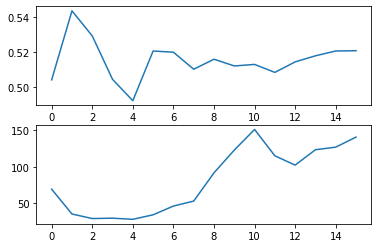

In [4]:
plt.subplot(211)
plt.plot(Ms)
plt.subplot(212)
plt.plot(Ts)

Evaluating segmenter...
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Pmean: 0.4299190613661345 Pstv: 0.16259918746584023
Wmean: 0.5240880388000552 Wstv: 0.14721276019145885
Evaluating segmenter done in 0.43 s


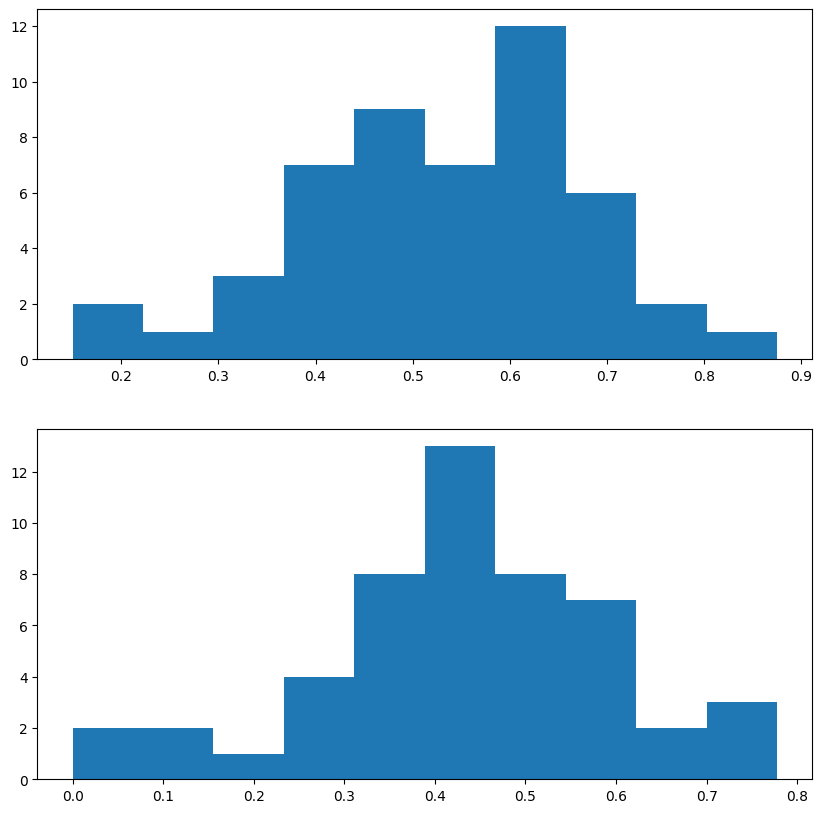

In [10]:
from evaluation import evaluate_segmenter
from algorithms import simple, graphseg
from datasets import EmbeddedDataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
with EmbeddedDataset('wiki_segments.npz') as ds:
    p,w = evaluate_segmenter(ds,lol,4)
    plt.subplot(2,1,1)
    plt.hist(w)
    plt.subplot(2,1,2)
    plt.hist(p)
 


Evaluating:[..........][300/300] => DONE [0h 0min 1s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][300/300] => DONE [0h 0min 1s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][300/300] => DONE [0h 0min 1s][eta: 0h 0min 0s]   0min 0s]    
Evaluating:[..........][127/127] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0h 0min 0s][eta: 0h 0min 0s]   
Evaluating:[..........][127/127] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0h 0min 0s][eta: 0h 0min 0s]   
Evaluating:[..........][127/127] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0h 0min 0s][eta: 0h 0min 0s]   
0.47265466716185356 0.45548822176280773 0.6348535344237227


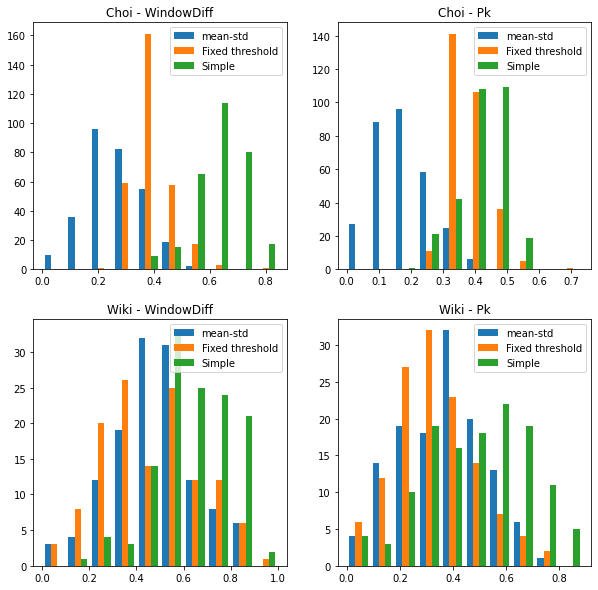

In [3]:
from evaluation import evaluate_segmenter
from algorithms import simple, graphseg, block_comparison
from datasets import EmbeddedDataset
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
gs = block_comparison.with_params(cmp_mode='acos', block_size=3, block_mode='max')
bs = block_comparison.with_params(cmp_mode='cos', block_size=5,threshold=0.6)



with EmbeddedDataset('choi_segments.npz') as ds:
    p1,w1 = evaluate_segmenter(ds,gs,4)
    p2,w2 = evaluate_segmenter(ds,bs,4)
    p3,w3 = evaluate_segmenter(ds,simple.simple_seg,4)

    ax = plt.subplot(2,2,1)
    ax.title.set_text("Choi - WindowDiff")
    plt.hist([w1,w2,w3], label = ["mean-std", "Fixed threshold", "Simple"])
    plt.legend()

    ax = plt.subplot(2,2,2)
    ax.title.set_text("Choi - Pk")
    plt.hist([p1,p2,p3], label = ["mean-std", "Fixed threshold", "Simple"])
    plt.legend()

with EmbeddedDataset('wiki_segments_trans_300.npz') as ds:
    p1,w1 = evaluate_segmenter(ds,gs,4)
    p2,w2 = evaluate_segmenter(ds,bs,4)
    p3,w3 = evaluate_segmenter(ds,simple.simple_seg,4)
    ax = plt.subplot(2,2,3)
    ax.title.set_text("Wiki - WindowDiff")
    plt.hist([w1,w2,w3], label = ["mean-std", "Fixed threshold", "Simple"])
    plt.legend()

    ax = plt.subplot(2,2,4)
    ax.title.set_text("Wiki - Pk")
    plt.hist([p1,p2,p3], label = ["mean-std", "Fixed threshold", "Simple"])
    plt.legend()
    print(np.mean(w1),np.mean(w2),np.mean(w3))




params:{'block_mode': 'sum', 'block_size': 1, 'cmp_mode': 'dot', 'substract_mean': True, 'whiten': True}, mean:0.443797443100505, std:0.13268599693286867
params:{'block_mode': 'sum', 'block_size': 1, 'cmp_mode': 'dot', 'substract_mean': True, 'whiten': False}, mean:0.4157582784669042, std:0.15160491618044164
params:{'block_mode': 'sum', 'block_size': 1, 'cmp_mode': 'dot', 'substract_mean': False, 'whiten': True}, mean:0.44015237753832737, std:0.13441868678170626
params:{'block_mode': 'sum', 'block_size': 1, 'cmp_mode': 'dot', 'substract_mean': False, 'whiten': False}, mean:0.42879032688517943, std:0.13361437695687384
params:{'block_mode': 'sum', 'block_size': 1, 'cmp_mode': 'cos', 'substract_mean': True, 'whiten': True}, mean:0.43513003965650965, std:0.13974467226981205
params:{'block_mode': 'sum', 'block_size': 1, 'cmp_mode': 'cos', 'substract_mean': True, 'whiten': False}, mean:0.41388061176257274, std:0.15241292031712608
params:{'block_mode': 'sum', 'block_size': 1, 'cmp_mode': 'cos

(array([30., 17., 25., 13.,  7.,  1.,  6.,  1.,  6.,  2.]),
 array([0.3682914 , 0.375842  , 0.38339261, 0.39094321, 0.39849381,
        0.40604442, 0.41359502, 0.42114563, 0.42869623, 0.43624684,
        0.44379744]),
 <BarContainer object of 10 artists>)

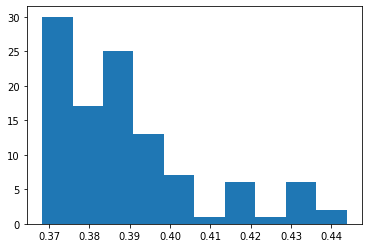

In [1]:
from sklearn.model_selection import ParameterGrid
import numpy as np
from datasets import EmbeddedDataset
from algorithms import block_comparison
from evaluation import evaluate_segmenter
import matplotlib.pyplot as plt

block_grid = ParameterGrid({'block_size':np.arange(1,10), 'whiten':[True, False], 'cmp_mode':['dot','cos','acos'], 'block_mode':['sum'], 'substract_mean':[True,False]})
Ms, Sts = [], []
with EmbeddedDataset('wiki_segments_trans_300.npz') as ds:
    for p in block_grid:
        bs = block_comparison.with_params(**p)
        w,_ = evaluate_segmenter(ds,bs,4,silent = True)
        Ms.append(np.mean(w))
        Sts.append(np.std(w))
        print(f'params:{p}, mean:{Ms[-1]}, std:{Sts[-1]}')
        
 

plt.hist(Ms)




In [2]:
m_i = np.argmin(Ms)
print(f'Minimal mean: {Ms[m_i]} std:{Sts[m_i]} for params: {block_grid[m_i]}')

Minimal mean: 0.3682913955427513 std:0.15152744993526598 for params: {'whiten': True, 'substract_mean': True, 'cmp_mode': 'cos', 'block_size': 8, 'block_mode': 'sum'}


(10, 2)
[[-0.28532156  0.95843184]
 [-0.79351944 -0.6085448 ]
 [-0.1542263   0.98803556]
 [-0.93755955  0.3478249 ]
 [-0.16058826  0.98702145]
 [ 0.64016664  0.76823604]
 [-0.9433011   0.3319385 ]
 [-0.77272487 -0.63474107]
 [ 0.09373005  0.99559766]
 [-0.6957825  -0.71825266]]
[0.5758334  1.3598466  0.71033096 0.35037056 0.7038886  1.5598905
 0.3672633  1.3932945  0.9590431  1.5069087 ]
4
[1 1 3 3 3 3 4 4 5 5]
[-0.35684052 -0.47888237  0.4882597   0.4938717   0.6554622  -0.34886274
  0.5182172  -0.7043743  -0.7803064 ]


array([0.5758334 , 1.3598466 , 0.71033096, 0.35037056, 0.7038886 ,
       1.5598905 , 0.3672633 , 1.3932945 , 0.9590431 , 1.5069087 ],
      dtype=float32)

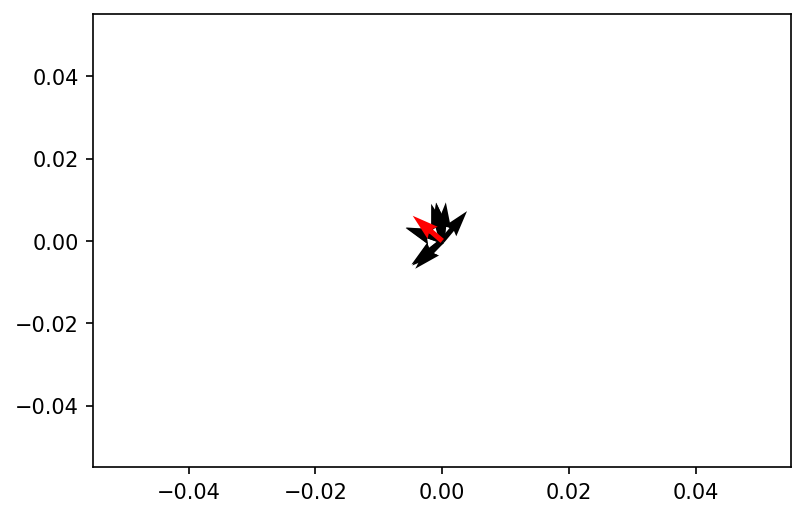

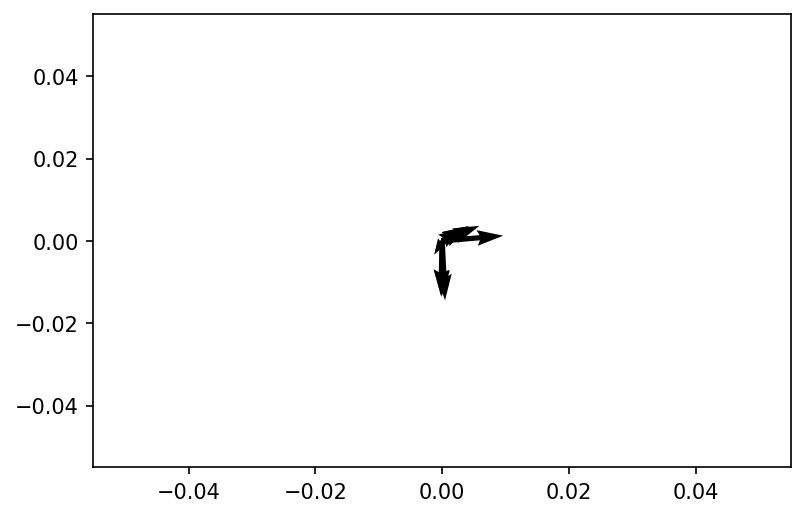

In [7]:
import matplotlib as mpl
from datasets import EmbeddedDataset
from sklearn.model_selection import ParameterGrid
import numpy as np
from datasets import EmbeddedDataset
from algorithms import block_comparison
from evaluation import evaluate_segmenter
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150
with EmbeddedDataset('wiki_segments.npz') as ds:
    seg,emb = ds.get_file('data/6540154')
emb.shape
origin = np.zeros((2,len(emb)+1))
a = emb[:,0:2]
print(a.shape)

a /= np.sqrt(np.einsum('...i,...i', a,a))[:,np.newaxis]
s = np.sum(a,0)
s /= np.sqrt(s.dot(s.T))
print(a)
plt.quiver(*np.zeros((2,len(a))),a[:,0],a[:,1])
plt.quiver(0,0,*s,color='red')
plt.figure()
coss = np.arccos(np.array([(i.dot(s.T))/np.sqrt(i.dot(i)*s.dot(s)) for i in a]))
print(coss)
print((coss>1).sum())
print(seg)
a = a-s
v = emb[:,0:2]
sc = np.array([v[i].dot(v[i+1]) for i in range(len(v)-1)])
print(sc)
plt.quiver(*np.zeros((2,len(a))),a[:,0],a[:,1])
def angle_deviations(a):
    s = np.sum(a,0)
    s /= np.sqrt(s.dot(s.T))
    return np.arccos(np.array([(i.dot(s.T))/np.sqrt(i.dot(i)*s.dot(s)) for i in a]))
angle_deviations(v)

In [12]:
from algorithms import segments
with EmbeddedDataset('wiki_segments.npz') as ds:
    diff = 0.0
    i = 0
    for seg in ds.get_segments():
        i += 1
        emb = ds.embbeding(seg)
        print(f'{segments.count(ds[seg])} - {(angle_deviations(ds[emb]) > 1.3).sum()}')
        d = abs( segments.count(ds[seg])- (angle_deviations(ds[emb]) > 1).sum())
        print(d)
        diff += d

    print(diff/i)



7 - 8
25
6 - 3
26
3 - 2
14
4 - 0
20
3 - 1
11
4 - 7
47
4 - 0
9
5 - 4
25
3 - 0
2
7 - 11
69
10 - 5
24
6 - 5
44
8 - 4
20
59 - 84
310
6 - 11
32
4 - 0
6
19 - 24
70
9 - 6
11
6 - 7
80
6 - 19
60
4 - 2
15
22 - 36
165
3 - 2
10
3 - 0
7
37 - 57
186
11 - 25
86
6 - 12
33
3 - 1
10
3 - 1
2
6 - 7
49
4 - 2
6
4 - 4
22
8 - 12
36
6 - 10
25
3 - 0
26
8 - 7
51
6 - 2
12
4 - 0
6
5 - 3
8
4 - 2
12
3 - 0
3
3 - 0
3
3 - 1
5
3 - 1
14
13 - 21
83
4 - 4
18
7 - 3
32
5 - 16
50
4 - 1
9
10 - 11
50
38.78


In [31]:
from nltk.tokenize.texttiling import TextTilingTokenizer
import nltk
from datasets import wikiset
from evaluation import evaluate_document
import algorithms

nltk.download('stopwords')
lines = wikiset.get_unsegmented_lines(wikiset.get(),'data/988580')
text= '\n'.join(lines)
#print(text)
ttt = TextTilingTokenizer(demo_mode=True)
s, ss, d, ttSegmentation = ttt.tokenize(text)
with EmbeddedDataset('wiki_segments.npz') as ds:
   seg, emb = ds.get_file('data/988580')

simpleSegmentation = algorithms.simple_seg(emb)
sgsSegmentation = sbert_graphseg(emb)
print(len(lines))
print(segments.array_to_nltk(np.array(ttSegmentation)))
print(segments.array_to_nltk(segments.tags_to_array(seg)))
print(len(sgsSegmentation))
#evaluate_document(seg,ttSegmentation)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Radek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


f:\progs\python\magister\data\wiki_727K.tar.bz2 found: True
f:\progs\python\magister\data\wiki_test_50.tar.bz2 found: True
['data/111174', 'data/2640796', 'data/2917712', 'data/10037144', 'data/2952485', 'data/3275069', 'data/6146176', 'data/6544206', 'data/1928841', 'data/12720971', 'data/28187', 'data/7445232', 'data/109461', 'data/7674758', 'data/1198312', 'data/3384438', 'data/2025011', 'data/988580', 'data/149766', 'data/599217', 'data/3881783', 'data/2842974', 'data/31444', 'data/1057453', 'data/1276536', 'data/338825', 'data/9652769', 'data/582816', 'data/961796', 'data/1064845', 'data/380143', 'data/5160544', 'data/7150404', 'data/9387798', 'data/2651177', 'data/7370490', 'data/44426', 'data/6261767', 'data/426889', 'data/6540154', 'data/10648433', 'data/123319', 'data/4074782', 'data/32431', 'data/910628', 'data/8718322', 'data/751683', 'data/2070518', 'data/4823815', 'data/3475652']
149
000001000100010000100010001000010000001000100010000010000000001000000010001000000001000100